### 一、正则化防止过拟合
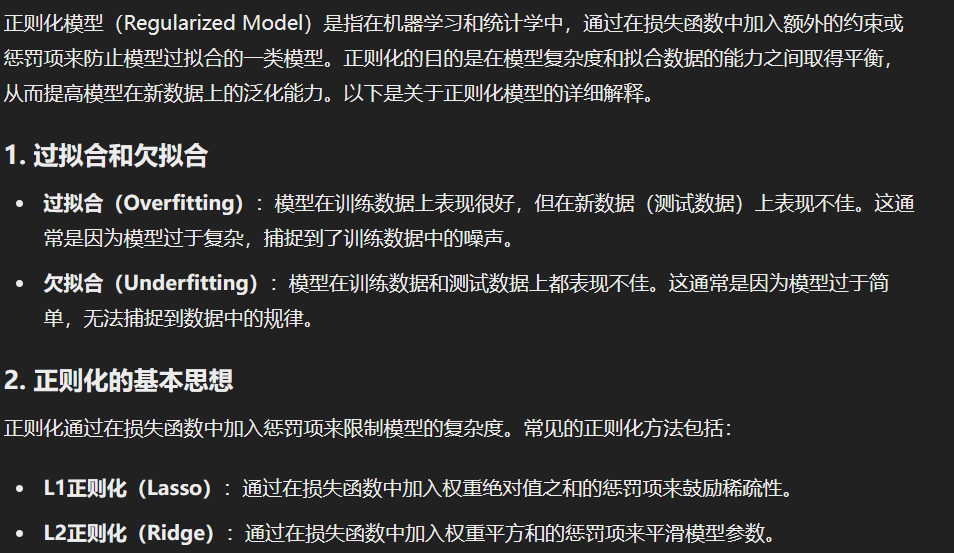

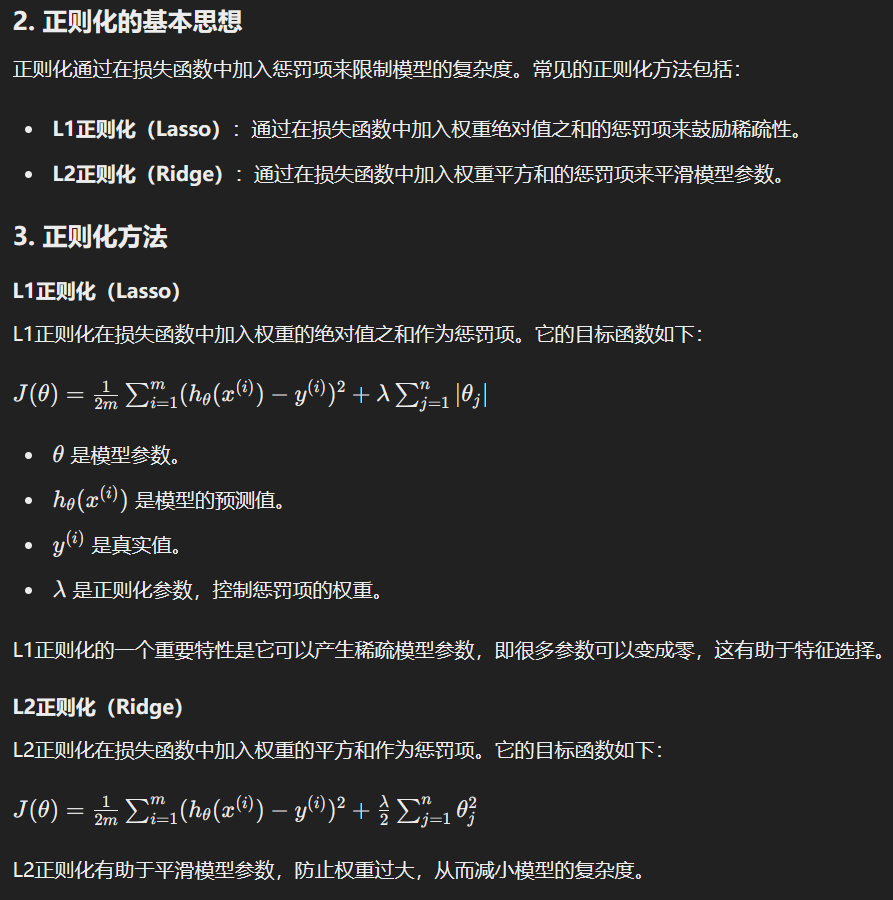
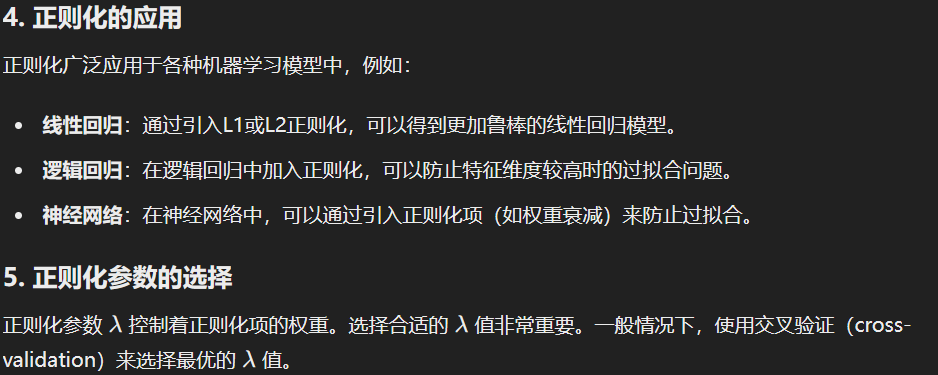

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

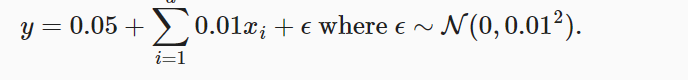

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [4]:
// L2范数惩罚
def l2_penalty(w):
    return (w**2).sum() / 2

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # 增加了L2范数惩罚项，
                # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', np.linalg.norm(w))

w的L2范数是： 13.259388


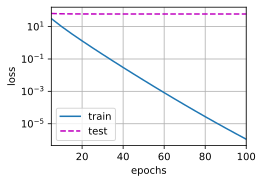

In [6]:
train(lambd=0)

w的L2范数是： 0.015867282


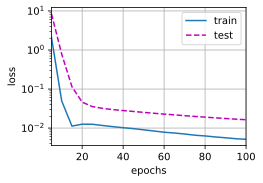

In [10]:
train(lambd=20)

## 二、 暂退法（dropout）

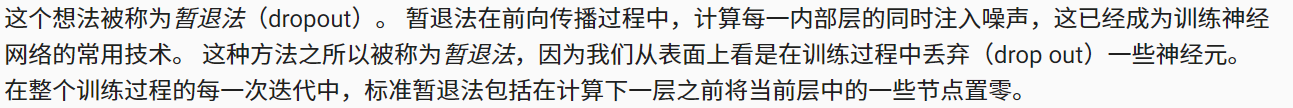

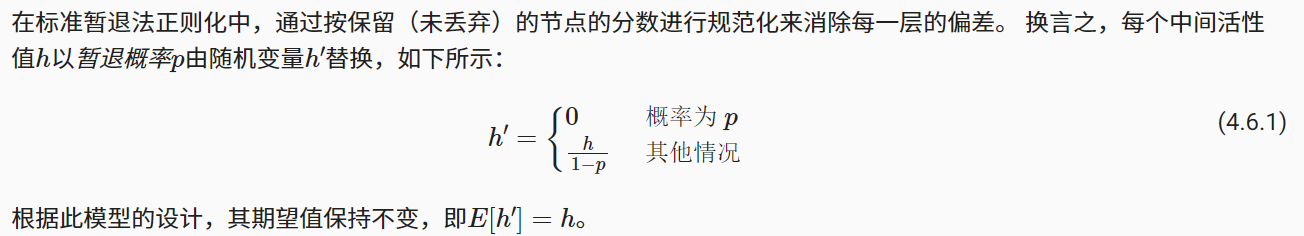

In [14]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return np.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    # 随机某个概率大于某个值就丢弃
    mask = np.random.uniform(0, 1, X.shape) > dropout
    print(mask)
    return mask.astype(np.float32) * X / (1.0 - dropout)

In [15]:
X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ True False False  True False  True False False]
 [False  True False False  True  True  True False]]
[[ 0.  0.  0.  6.  0. 10.  0.  0.]
 [ 0. 18.  0.  0. 24. 26. 28.  0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [16]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

In [19]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # 只有在训练模型时才使用dropout
    if autograd.is_training():
        # 在第一个全连接层之后添加一个dropout层
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2) # 第一层选择激活之后的神经元输出消失
    if autograd.is_training():
        # 在第二个全连接层之后添加一个dropout层
        H2 = dropout_layer(H2, dropout2) # 第二层选择激活之后的神经元输出消失
    return np.dot(H2, W3) + b3 

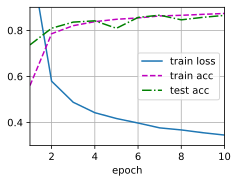

In [20]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

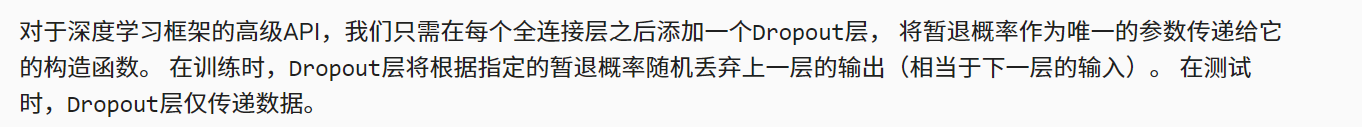

In [21]:
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Dense(256, activation="relu"),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

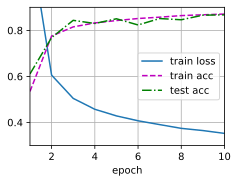

In [22]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)